In [54]:
import os
import sys

import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import plotly.graph_objects as go
from itertools import permutations
import optax
import chex
from tqdm import tqdm


# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries
from utils.geometries import trigonal_plane, tetrahedron, octahedron, icosahedron, dodecahedron
from utils.alignment import sample_uniform_quaternion, align_signals, find_best_random_quaternion, rotate_points_quaternion, stack_points, point_distance, spherical_harmonic_distance, stack_points, choose_best_quaternion, evenly_distributed_quaternions, quaternion_rotation_distance, spherical_grid_distance
import spectra
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)


def radius_mae(arr1, arr2):
    """
    Compute the minimum average of the absolute differences between two arrays
    by trying all possible permutations of the second array.
    
    Parameters:
    arr1 (numpy.ndarray): First 1D numpy array
    arr2 (numpy.ndarray): Second 1D numpy array of the same length as arr1
    
    Returns:
    float: Minimum average absolute difference
    tuple: The permutation of arr2 that gives the minimum difference
    """

    arr1_norms = jnp.linalg.norm(arr1, axis=1)
    arr2_norms = jnp.linalg.norm(arr2, axis=1)

    if len(arr1_norms) != len(arr2_norms):
        return jnp.nan
    
    if len(arr1) == 0:
        return 0, []
    
    min_avg = float('inf')
    best_perm = None
    
    # Generate all permutations of arr2
    for perm in permutations(arr2_norms):
        perm_arr = jnp.array(perm)
        # Calculate absolute differences
        abs_diff = jnp.abs(arr1_norms - perm_arr)
        # Calculate mean of absolute differences
        avg_diff = jnp.mean(abs_diff)
        
        # Update minimum if current permutation gives better result
        if avg_diff < min_avg:
            min_avg = avg_diff
            best_perm = perm
    
    return float(min_avg)


def invert(true_spectrum, spectrum_function, lmax, mask_index=None, initial_points=None, n_points=20, learning_rate=1e-2, 
                     seed=0, num_iterations=100000, patience=5000):
    """
    Inverts either the power spectrum or bispectrum to a signal with adaptive learning rate.
    Returns the final signal and history of points saved every 100 iterations.
    
    Args:
        true_spectrum: Target spectrum to match
        spectrum_function: Either powerspectrum or bispectrum
        lmax: Maximum degree for spherical harmonics
        mask_index: Index of the bispectrum component to mask in loss calculation (None to use all components)
        initial_points: Initial point locations (None for random initialization)
        learning_rate: Initial learning rate
        seed: Random seed for initialization
        num_iterations: Maximum number of iterations
        
    Returns:
        tuple: (best_points, points_history, losses_history)
            - best_points: Points that achieved the lowest loss
            - points_history: Dictionary with iteration numbers as keys and points at those iterations as values
            - losses_history: Dictionary with iteration numbers as keys and loss values at those iterations
    """
    def loss(
        params: optax.Params, true_spectrum: chex.Array
    ) -> chex.Array:
        """Computes the loss corresponding to the current parameters."""
        predicted_signal = sum_of_diracs(params["points"], lmax)
        pred_spectrum = spectrum_function(predicted_signal)
        
        if mask_index is not None:
            # Create a mask that is True for all indices except the one to be masked
            mask = jnp.ones_like(true_spectrum, dtype=bool)
            mask = mask.at[mask_index].set(False)
            
            # Apply the mask to both true and predicted spectra
            masked_true = true_spectrum * mask
            masked_pred = pred_spectrum * mask
            
            # Compute L1 loss only on unmasked elements
            return jnp.abs(masked_true - masked_pred).mean()
            # return optax.l2_loss(masked_true, masked_pred).mean()
        else:
            # Original behavior when no masking is requested
            return jnp.abs(true_spectrum - pred_spectrum).mean()
            # return optax.l2_loss(true_spectrum, pred_spectrum).mean()

    def fit(
        params: optax.Params,
        learning_rate: float,
        true_spectrum: chex.Array,
        max_iter: int = num_iterations,
    ):
        # Create optimizer with fixed learning rate
        optimizer = optax.adam(learning_rate=learning_rate)        
        opt_state = optimizer.init(params)
        
        # Track optimization progress
        min_loss = float('inf')
        no_improvement_count = 0
        
        # Save best parameters
        best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
        
        # Initialize points history dictionary
        points_history = {}
        losses_history = {}
        
        # Pure function to update parameters - JIT compatible
        @jax.jit
        def step(params, opt_state, true_spectrum, step_idx):
            loss_value, grads = jax.value_and_grad(loss)(
                params, true_spectrum
            )
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value
        
        for iter in range(max_iter):
            # Pass iteration count to the step function
            params, opt_state, loss_value = step(
                params, opt_state, true_spectrum, iter
            )
            
            # Save points every iterations
            if iter % 100 == 0:
                # We need to convert JAX arrays to numpy arrays for the history
                points_history[iter] = jax.device_get(params["points"])
                losses_history[iter] = jax.device_get(loss_value)
                # print(f"step {iter}, loss: {loss_value}")
            
            # Check if loss decreased
            if loss_value < min_loss:
                min_loss = loss_value
                no_improvement_count = 0
                # Save the best parameters
                best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
            else:
                no_improvement_count += 1
                
            # Early stopping if no improvement for patience iterations
            if no_improvement_count >= patience:
                # print(f"Stopping early at step {iter}: no improvement for {patience} iterations")
                # Save the final points before breaking
                if iter % 100 != 0:  # Only if we haven't just saved them
                    points_history[iter] = jax.device_get(params["points"])
                    losses_history[iter] = jax.device_get(loss_value)
                break

        # Return the best parameters found during optimization
        # print(f"Final best loss: {min_loss}")
        return best_params, points_history, losses_history
    
    if initial_points is None and n_points is None:
        rng = jax.random.PRNGKey(seed)
        initial_points = dodecahedron + 0.1 * jax.random.normal(rng, (dodecahedron.shape[0], 3))
    elif initial_points is None and n_points is not None:
        rng = jax.random.PRNGKey(seed)
        initial_points = jax.random.normal(rng, (n_points, 3))
    init_params = {"points": initial_points}
    
    # Create optimizer with fixed learning rate
    final_params, points_history, losses_history = fit(init_params, learning_rate, true_spectrum)
    
    # Return both the best points and the history of points
    return final_params["points"], points_history, losses_history



In [80]:
def invert_with_sgd(true_spectrum, spectrum_function, lmax, mask_index=None, initial_points=None, n_points=20, learning_rate=1e-2, 
                     seed=0, num_iterations=100000, patience=5000):
    """
    Inverts either the power spectrum or bispectrum to a signal with vanilla gradient descent.
    Returns the final signal and history of points saved every 100 iterations.
    
    Args:
        true_spectrum: Target spectrum to match
        spectrum_function: Either powerspectrum or bispectrum
        lmax: Maximum degree for spherical harmonics
        mask_index: Index of the bispectrum component to mask in loss calculation (None to use all components)
        initial_points: Initial point locations (None for random initialization)
        learning_rate: Initial learning rate
        seed: Random seed for initialization
        num_iterations: Maximum number of iterations
        
    Returns:
        tuple: (best_points, points_history, losses_history)
            - best_points: Points that achieved the lowest loss
            - points_history: Dictionary with iteration numbers as keys and points at those iterations as values
            - losses_history: Dictionary with iteration numbers as keys and loss values at those iterations
    """
    def loss(
        params: optax.Params, true_spectrum: chex.Array
    ) -> chex.Array:
        """Computes the loss corresponding to the current parameters."""
        predicted_signal = sum_of_diracs(params["points"], lmax)
        pred_spectrum = spectrum_function(predicted_signal)
        
        if mask_index is not None:
            # Create a mask that is True for all indices except the one to be masked
            mask = jnp.ones_like(true_spectrum, dtype=bool)
            mask = mask.at[mask_index].set(False)
            
            # Apply the mask to both true and predicted spectra
            masked_true = true_spectrum * mask
            masked_pred = pred_spectrum * mask
            
            # Compute L1 loss only on unmasked elements
            return jnp.abs(masked_true - masked_pred).mean()
        else:
            # Original behavior when no masking is requested
            return jnp.abs(true_spectrum - pred_spectrum).mean()

    def fit(
        params: optax.Params,
        learning_rate: float,
        true_spectrum: chex.Array,
        max_iter: int = num_iterations,
    ):
        # Create optimizer with vanilla gradient descent instead of Adam
        optimizer = optax.sgd(learning_rate=learning_rate)        
        opt_state = optimizer.init(params)
        
        # Track optimization progress
        min_loss = float('inf')
        no_improvement_count = 0
        
        # Save best parameters
        best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
        
        # Initialize points history dictionary
        points_history = {}
        losses_history = {}
        
        # Pure function to update parameters - JIT compatible
        @jax.jit
        def step(params, opt_state, true_spectrum, step_idx):
            loss_value, grads = jax.value_and_grad(loss)(
                params, true_spectrum
            )
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value
        
        for iter in range(max_iter):
            # Pass iteration count to the step function
            params, opt_state, loss_value = step(
                params, opt_state, true_spectrum, iter
            )
            
            # Save points every iterations
            if iter % 100 == 0:
                # We need to convert JAX arrays to numpy arrays for the history
                points_history[iter] = jax.device_get(params["points"])
                losses_history[iter] = jax.device_get(loss_value)
            
            # Check if loss decreased
            if loss_value < min_loss:
                min_loss = loss_value
                no_improvement_count = 0
                # Save the best parameters
                best_params = jax.tree_util.tree_map(lambda x: x.copy(), params)
            else:
                no_improvement_count += 1
                
            # Early stopping if no improvement for patience iterations
            if no_improvement_count >= patience:
                # Save the final points before breaking
                if iter % 100 != 0:  # Only if we haven't just saved them
                    points_history[iter] = jax.device_get(params["points"])
                    losses_history[iter] = jax.device_get(loss_value)
                break

        # Return the best parameters found during optimization
        return best_params, points_history, losses_history
    
    if initial_points is None and n_points is None:
        rng = jax.random.PRNGKey(seed)
        initial_points = dodecahedron + 0.1 * jax.random.normal(rng, (dodecahedron.shape[0], 3))
    elif initial_points is None and n_points is not None:
        rng = jax.random.PRNGKey(seed)
        initial_points = jax.random.normal(rng, (n_points, 3))
    init_params = {"points": initial_points}
    
    # Run optimization with vanilla gradient descent
    final_params, points_history, losses_history = fit(init_params, learning_rate, true_spectrum)
    
    # Return both the best points and the history of points
    return final_params["points"], points_history, losses_history

In [2]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 10000


In [3]:
index = 0

true_geometry = jnp.array(local_envs[index])
print("Number of points:", len(true_geometry))

Number of points: 4


Number of points: 4


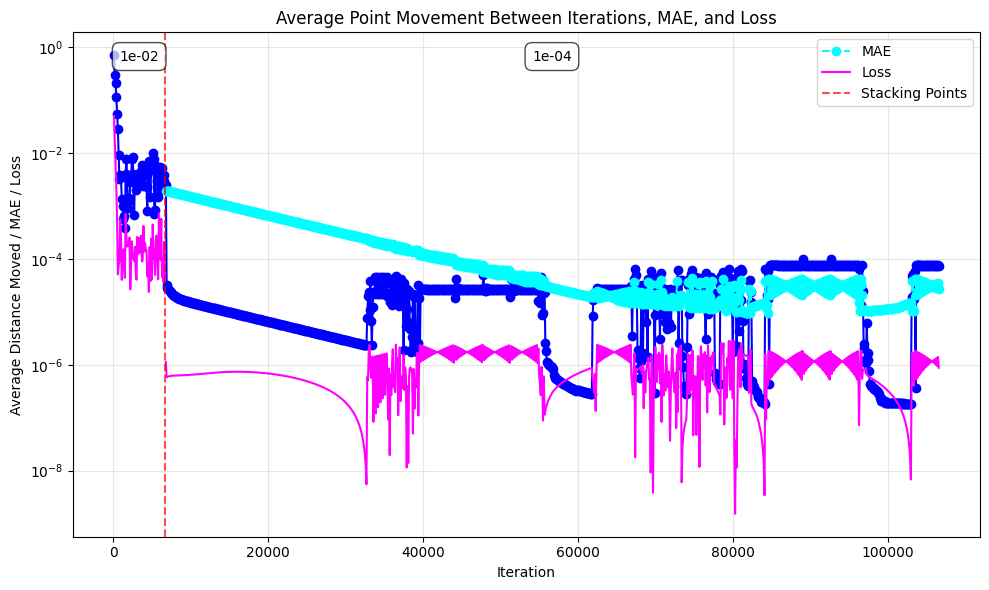

In [10]:
index = 0
lmax = 4

true_geometry = jnp.array(local_envs[index])
print("Number of points:", len(true_geometry))
true_signal = sum_of_diracs(true_geometry, lmax)
true_bispectrum = bispectrum(true_signal)

# Define a list of learning rates to use in sequence
# learning_rates = [1e-2, 1e-4, 1e-3, 1e-2, 1e-1, 1e-2, 1e-3, 1e-4]
learning_rates = [1e-2, 1e-4]


# Initialize variables to store results
all_points_history = []
all_losses_history = []
max_iters = []
iterations_list = []
avg_distances_list = []
mae_values_list = []
loss_values_list = []

# Run the initial inversion
predicted_points, points_history, losses_history = invert(true_bispectrum, bispectrum, lmax, n_points=10, learning_rate=learning_rates[0], patience=5000)
all_points_history.append(points_history)
all_losses_history.append(losses_history)
max_iters.append(max(points_history.keys()))

# Stack points after first inversion
stacked_points = stack_points(predicted_points)
current_points = stacked_points

# Track the best points and lowest loss
best_loss = float('inf')
best_predicted_geometry = None

# Check if the initial result is the best so far
min_loss_key = min(losses_history, key=losses_history.get)
if losses_history[min_loss_key] < best_loss:
    best_loss = losses_history[min_loss_key]
    best_predicted_geometry = points_history[min_loss_key]

# Run subsequent inversions with different learning rates
for i in range(1, len(learning_rates)):
    predicted_points, points_history, losses_history = invert(true_bispectrum, bispectrum, lmax, initial_points=current_points, learning_rate=learning_rates[i], patience=100000)
    all_points_history.append(points_history)
    all_losses_history.append(losses_history)
    max_iters.append(max(points_history.keys()))
    current_points = predicted_points
    
    # Check if this phase produced a better result
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_predicted_geometry = points_history[min_loss_key]

# Process each phase's history
for phase, points_history in enumerate(all_points_history):
    keys = sorted(points_history.keys())
    
    # Calculate average distance moved between consecutive iterations
    avg_distances = []
    for i in range(len(keys) - 1):
        current_points = points_history[keys[i]]
        next_points = points_history[keys[i+1]]
        
        # Calculate Euclidean distance for each point between iterations
        distances = jnp.linalg.norm(next_points - current_points, axis=1)
        
        # Calculate the average distance moved across all points
        avg_distance = jnp.mean(distances)
        avg_distances.append(avg_distance)
    
    # Calculate iteration offsets for continuous plotting
    offset = sum(max_iters[:phase]) if phase > 0 else 0
    iterations = [keys[i+1] + offset for i in range(len(keys) - 1)]
    
    # Calculate MAE for each iteration
    mae_values = []
    for i in range(len(keys) - 1):
        current_points = points_history[keys[i+1]]
        mae = radius_mae(current_points, true_geometry)
        mae_values.append(mae)
    
    # Extract loss values
    loss_values = [all_losses_history[phase][keys[i+1]] for i in range(len(keys) - 1)]
    
    # Store processed data
    iterations_list.append(iterations)
    avg_distances_list.append(avg_distances)
    mae_values_list.append(mae_values)
    loss_values_list.append(loss_values)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot average distance moved for all phases with the same color
for phase in range(len(all_points_history)):
    plt.plot(iterations_list[phase], avg_distances_list[phase], marker='o', linestyle='-', color='blue')

# Plot MAE values with a single legend entry
for phase in range(len(all_points_history)):
    label = 'MAE' if phase == 0 else None
    plt.plot(iterations_list[phase], mae_values_list[phase], marker='o', linestyle='--', color='cyan', label=label)

# Plot loss values with a single legend entry
for phase in range(len(all_points_history)):
    label = 'Loss' if phase == 0 else None
    plt.plot(iterations_list[phase], loss_values_list[phase], linestyle='-', color='magenta', label=label)

# Add vertical lines to separate the inversion phases
cumulative_iters = 0
for phase in range(len(max_iters) - 1):
    cumulative_iters += max_iters[phase]
    label = 'Stacking Points' if phase == 0 else None
    plt.axvline(x=cumulative_iters, color='red' if phase == 0 else 'gray', 
                linestyle='--', alpha=0.7, label=label)

# Annotate each phase with its learning rate
cumulative_iters = 0
y_pos = plt.ylim()[1] * 0.9  # Position annotations near the top
for phase, lr in enumerate(learning_rates):
    # Calculate the midpoint of this phase for annotation placement
    if phase == 0:
        midpoint = max_iters[phase] / 2
    else:
        midpoint = cumulative_iters + max_iters[phase] / 2
    
    # Add annotation with the learning rate
    plt.annotate(f'{lr:.0e}', xy=(midpoint, y_pos), 
                 xytext=(0, 0), textcoords='offset points',
                 ha='center', va='center', 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))
    
    # Update cumulative iterations for next phase
    cumulative_iters += max_iters[phase]

plt.xlabel('Iteration')
plt.ylabel('Average Distance Moved / MAE / Loss')
plt.title('Average Point Movement Between Iterations, MAE, and Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale often helps visualize convergence
plt.legend()
plt.tight_layout()
plt.show()

In [102]:
def multi_stage_inversion(true_bispectrum, lmax, n_points=10, learning_rates=[1e-2, 1e-4]):
    """
    Performs multi-stage inversion of a bispectrum with different learning rates.
    
    Args:
        true_bispectrum: Target bispectrum to match
        lmax: Maximum degree for spherical harmonics
        n_points: Number of points to use for initial inversion
        
    Returns:
        jnp.ndarray: The predicted geometry with the lowest loss
    """
    # Run the initial inversion
    predicted_points, _, losses_history = invert(true_bispectrum, bispectrum, lmax, n_points=n_points, learning_rate=learning_rates[0], patience=5000)
    
    # Stack points after first inversion
    stacked_points = stack_points(predicted_points)
    current_points = stacked_points
    
    # Track the best points and lowest loss
    best_loss = float('inf')
    best_points = None
    
    # Store the initial result if it's the best so far
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_points = predicted_points
    
    # Run subsequent inversion with different learning rate
    predicted_points, points_history, losses_history = invert(true_bispectrum, bispectrum, lmax, initial_points=current_points, learning_rate=learning_rates[1], num_iterations=5000, patience=5000)
    current_points = predicted_points
    
    # Check if this phase produced a better result
    min_loss_key = min(losses_history, key=losses_history.get)
    if losses_history[min_loss_key] < best_loss:
        best_loss = losses_history[min_loss_key]
        best_points = predicted_points
    
    return best_points, points_history

# index = 1

# true_geometry = jnp.array(local_envs[index])
# true_signal = sum_of_diracs(true_geometry, lmax)
# true_bispectrum = bispectrum(true_signal)

# # Run the multi-stage inversion
# predicted_geometry = multi_stage_inversion(true_bispectrum, lmax, n_points=10)

# # Calculate MAE for the final result
# final_mae = radius_mae(predicted_geometry, true_geometry)
# print(f"Final MAE: {final_mae}")


In [110]:
num_envs = 10
predicted_geometries = []
mae_list = {i: [] for i in range(num_envs)}
for index in tqdm(range(num_envs)):
    true_geometry = jnp.array(local_envs[index]) * 50
    true_signal = sum_of_diracs(true_geometry, lmax)
    true_bispectrum = bispectrum(true_signal)
    predicted_geometry, points_history = multi_stage_inversion(true_bispectrum, lmax, n_points=10, learning_rates=[1e-2, 1e-2])
    predicted_geometries.append(predicted_geometry)

    for iteration, points in points_history.items():
        mae_list[index].append(radius_mae(points, true_geometry))

mae_list = {i: jnp.array(mae_list[i]) for i in range(num_envs)}

100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


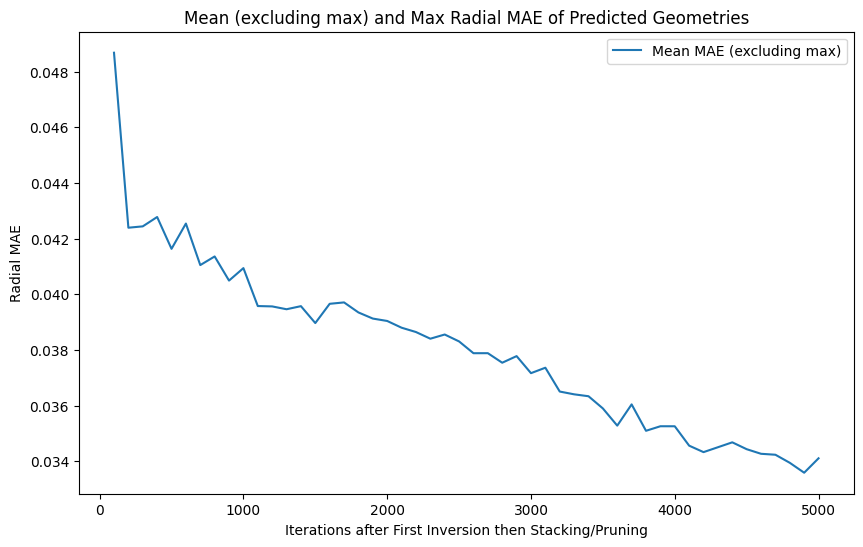

In [111]:
mae_means = []
mae_maxes = []

for iteration in range(len(mae_list[0])):
    # Collect all MAEs for this iteration across environments
    iteration_maes = jnp.array([mae_list[i][iteration] for i in range(num_envs)])
    # Calculate mean without considering the maximum value
    sorted_maes = jnp.sort(iteration_maes)
    # Exclude the maximum value when calculating the mean
    mae_means.append(jnp.mean(sorted_maes[:-1]))
    mae_maxes.append(jnp.max(iteration_maes))

# Create x-axis values from 100 to 100000 with step size 100
x_values = jnp.arange(100, 100100, 100)[:50]

plt.figure(figsize=(10, 6))
plt.plot(x_values, mae_means, label='Mean MAE (excluding max)')
# plt.plot(x_values, mae_maxes, label='Max MAE')
plt.xlabel('Iterations after First Inversion then Stacking/Pruning')
plt.ylabel('Radial MAE')
plt.title('Mean (excluding max) and Max Radial MAE of Predicted Geometries')
plt.legend()
plt.show()

Running with learning rates: [0.01, 0.0001]


100%|██████████| 50/50 [02:12<00:00,  2.66s/it]


Running with learning rates: [0.01, 0.0002]


100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


Running with learning rates: [0.01, 0.0004]


100%|██████████| 50/50 [02:14<00:00,  2.68s/it]


Running with learning rates: [0.01, 0.0008]


100%|██████████| 50/50 [02:16<00:00,  2.72s/it]


Running with learning rates: [0.01, 0.001]


100%|██████████| 50/50 [02:09<00:00,  2.60s/it]


Running with learning rates: [0.01, 0.002]


100%|██████████| 50/50 [02:14<00:00,  2.68s/it]


Running with learning rates: [0.01, 0.004]


100%|██████████| 50/50 [02:19<00:00,  2.80s/it]


Running with learning rates: [0.01, 0.008]


100%|██████████| 50/50 [02:15<00:00,  2.72s/it]


Running with learning rates: [0.01, 0.01]


100%|██████████| 50/50 [02:14<00:00,  2.69s/it]


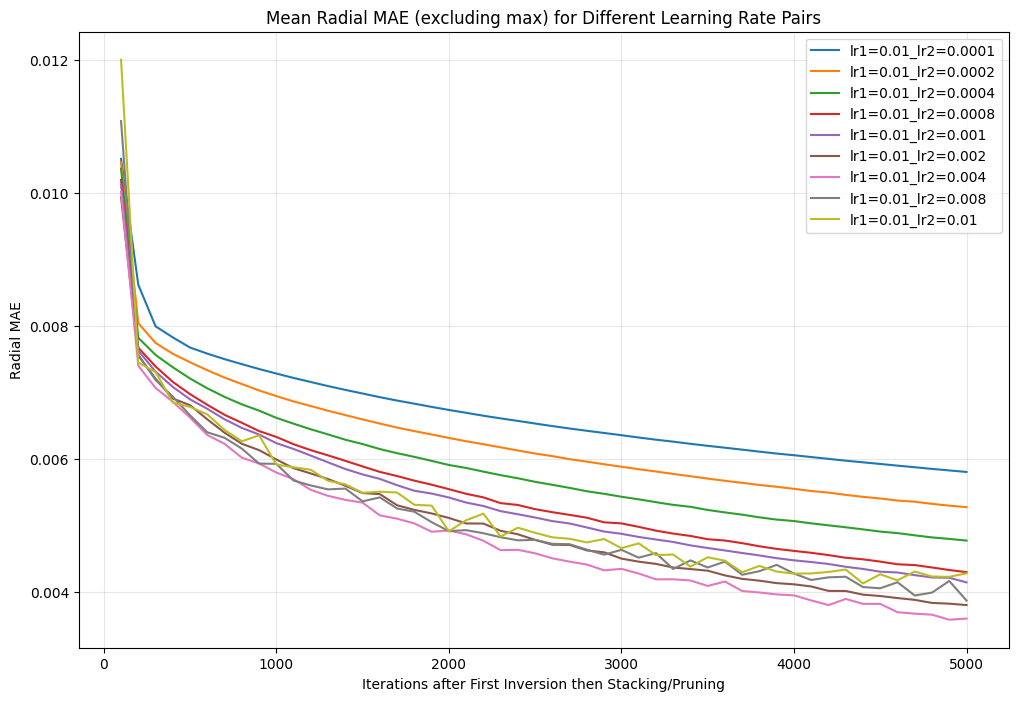

In [104]:
num_envs = 50
learning_rate_pairs = [
    [1e-2, 1e-4],
    [1e-2, 2e-4],
    [1e-2, 4e-4],
    [1e-2, 8e-4],
    [1e-2, 1e-3],
    [1e-2, 2e-3],
    [1e-2, 4e-3],
    [1e-2, 8e-3],
    [1e-2, 1e-2],
]

all_mae_means = {}
all_predicted_geometries = {}

for lr_pair in learning_rate_pairs:
    lr_name = f"lr1={lr_pair[0]}_lr2={lr_pair[1]}"
    print(f"Running with learning rates: {lr_pair}")
    
    predicted_geometries = []
    mae_list = {i: [] for i in range(num_envs)}
    
    for index in tqdm(range(num_envs)):
        true_geometry = jnp.array(local_envs[index])
        true_signal = sum_of_diracs(true_geometry, lmax)
        true_bispectrum = bispectrum(true_signal)
        
        # Pass the learning rate pair to multi_stage_inversion
        predicted_geometry, points_history = multi_stage_inversion(
            true_bispectrum, 
            lmax, 
            n_points=10, 
            learning_rates=lr_pair
        )
        
        predicted_geometries.append(predicted_geometry)

        for iteration, points in points_history.items():
            mae_list[index].append(radius_mae(points, true_geometry))

    mae_list = {i: jnp.array(mae_list[i]) for i in range(num_envs)}
    
    # Calculate mean MAEs for this learning rate pair
    mae_means = []
    mae_maxes = []

    for iteration in range(len(mae_list[0])):
        # Collect all MAEs for this iteration across environments
        iteration_maes = jnp.array([mae_list[i][iteration] for i in range(num_envs)])
        # Calculate mean without considering the maximum value
        sorted_maes = jnp.sort(iteration_maes)
        # Exclude the maximum value when calculating the mean
        mae_means.append(jnp.mean(sorted_maes[:-1]))
        mae_maxes.append(jnp.max(iteration_maes))
    
    all_mae_means[lr_name] = mae_means
    all_predicted_geometries[lr_name] = predicted_geometries

# Create x-axis values from 100 to 100000 with step size 100
x_values = jnp.arange(100, 100100, 100)[:50]

# Plot the results for all learning rate pairs
plt.figure(figsize=(12, 8))
for lr_pair, mae_means in all_mae_means.items():
    plt.plot(x_values, mae_means, label=f'{lr_pair}')

plt.xlabel('Iterations after First Inversion then Stacking/Pruning')
plt.ylabel('Radial MAE')
plt.title('Mean Radial MAE (excluding max) for Different Learning Rate Pairs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

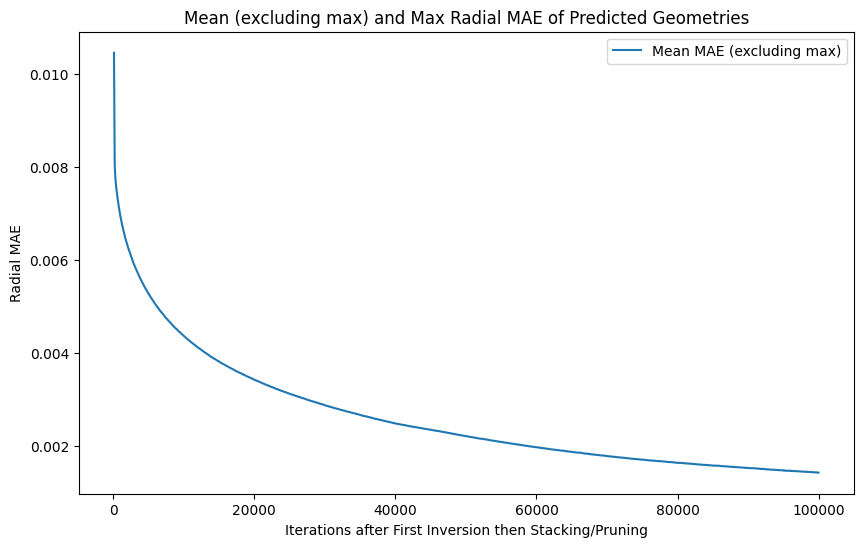

In [95]:
mae_means = []
mae_maxes = []

for iteration in range(len(mae_list[0])):
    # Collect all MAEs for this iteration across environments
    iteration_maes = jnp.array([mae_list[i][iteration] for i in range(num_envs)])
    # Calculate mean without considering the maximum value
    sorted_maes = jnp.sort(iteration_maes)
    # Exclude the maximum value when calculating the mean
    mae_means.append(jnp.mean(sorted_maes[:-1]))
    mae_maxes.append(jnp.max(iteration_maes))

# Create x-axis values from 100 to 100000 with step size 100
x_values = jnp.arange(100, 100100, 100)

plt.figure(figsize=(10, 6))
plt.plot(x_values, mae_means, label='Mean MAE (excluding max)')
# plt.plot(x_values, mae_maxes, label='Max MAE')
plt.xlabel('Iterations after First Inversion then Stacking/Pruning')
plt.ylabel('Radial MAE')
plt.title('Mean (excluding max) and Max Radial MAE of Predicted Geometries')
plt.legend()
plt.show()

In [44]:
# Save the MAE list to a file for later analysis
import pickle

# Convert JAX arrays to numpy for serialization
mae_list_np = {i: np.array(mae_list[i]) for i in range(num_envs)}

# Save to a pickle file
with open('mae_list_qm9_inversion.pkl', 'wb') as f:
    pickle.dump(mae_list_np, f)

print(f"MAE list saved for {num_envs} environments")

MAE list saved for 50 environments


In [45]:
# Load the previously saved MAE list for analysis
import pickle

# Open the pickle file and load the data
with open('mae_list_qm9_inversion.pkl', 'rb') as f:
    loaded_mae_list = pickle.load(f)

print(f"Loaded MAE data for {len(loaded_mae_list)} environments")

# Convert back to JAX arrays if needed for further processing
loaded_mae_list_jax = {i: jnp.array(loaded_mae_list[i]) for i in loaded_mae_list.keys()}

# Verify the data structure
print(f"Number of iterations in first environment: {len(loaded_mae_list[0])}")


Loaded MAE data for 50 environments
Number of iterations in first environment: 1000


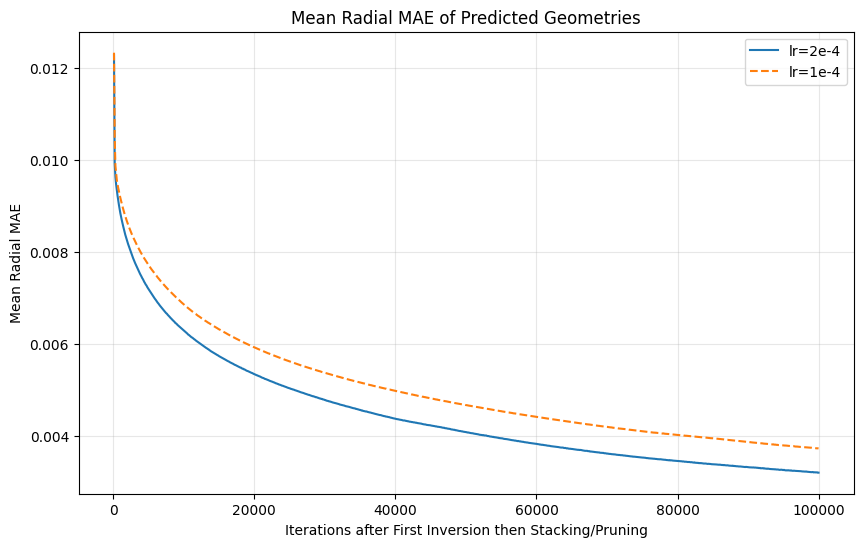

In [93]:
# Calculate mean MAE for the original data
mae_means = []
for iteration in range(len(mae_list[0])):
    mae_means.append(jnp.mean(jnp.array([mae_list[i][iteration] for i in range(num_envs)])))

# Calculate mean MAE for the loaded data
loaded_mae_means = []
for iteration in range(len(loaded_mae_list_jax[0])):
    loaded_mae_means.append(jnp.mean(jnp.array([loaded_mae_list_jax[i][iteration] for i in loaded_mae_list_jax.keys()])))

# Create x-axis values from 100 to 100000 with step size 100
x_values = jnp.arange(100, 100100, 100)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, mae_means, label='lr=2e-4')
plt.plot(x_values, loaded_mae_means, label='lr=1e-4', linestyle='--')
plt.xlabel('Iterations after First Inversion then Stacking/Pruning')
plt.ylabel('Mean Radial MAE')
plt.title('Mean Radial MAE of Predicted Geometries')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Number of environments with matching neighbor count: 50 out of 50
Average distance from origin (true): 1.216060
Standard deviation of distances (true): 0.179188
Average distance from origin (predicted): 1.216061
Standard deviation of distances (predicted): 0.179197


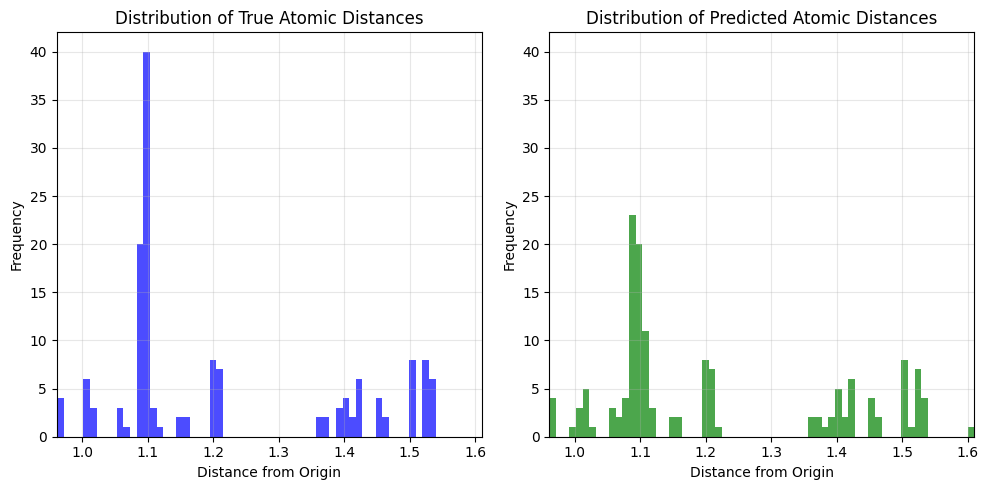

In [50]:
# Filter environments where the number of neighbors is the same
num_local_envs = len(predicted_geometries)
filtered_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_indices.append(i)

# Get the filtered environments
filtered_true_envs = [local_envs[i] for i in filtered_indices]
filtered_pred_envs = [predicted_geometries[i] for i in filtered_indices]

# Stack all filtered local environments into a single array
stacked_true_envs = jnp.vstack([jnp.array(env) for env in filtered_true_envs])
stacked_pred_envs = jnp.vstack(filtered_pred_envs)

# Calculate the row-wise norm (Euclidean distance from origin for each point)
true_norms = jnp.linalg.norm(stacked_true_envs, axis=1)
predicted_norms = jnp.linalg.norm(stacked_pred_envs, axis=1)

# Calculate statistics
avg_true_norm = jnp.mean(true_norms)
std_true_norm = jnp.std(true_norms)
avg_pred_norm = jnp.mean(predicted_norms)
std_pred_norm = jnp.std(predicted_norms)

print(f"Number of environments with matching neighbor count: {len(filtered_indices)} out of {num_local_envs}")
print(f"Average distance from origin (true): {avg_true_norm:.6f}")
print(f"Standard deviation of distances (true): {std_true_norm:.6f}")
print(f"Average distance from origin (predicted): {avg_pred_norm:.6f}")
print(f"Standard deviation of distances (predicted): {std_pred_norm:.6f}")

# Create side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Determine common x and y axis limits
min_x = min(jnp.min(true_norms), jnp.min(predicted_norms))
max_x = max(jnp.max(true_norms), jnp.max(predicted_norms))
# Use buckets of size 0.01
num_bins = int((max_x - min_x) / 0.01) + 1
bins = np.linspace(min_x, max_x, num_bins)

# True distances histogram
counts_true, bins_true, _ = ax1.hist(true_norms, bins=bins, alpha=0.7, color='blue')
ax1.set_xlabel('Distance from Origin')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of True Atomic Distances')
ax1.grid(alpha=0.3)

# Predicted distances histogram
counts_pred, bins_pred, _ = ax2.hist(predicted_norms, bins=bins, alpha=0.7, color='green')
ax2.set_xlabel('Distance from Origin')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Predicted Atomic Distances')
ax2.grid(alpha=0.3)

# Get the y-axis limits from both plots and use the same for both
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

# Ensure both plots have the same x-axis range
ax1.set_xlim(min_x, max_x)
ax2.set_xlim(min_x, max_x)

plt.tight_layout()
plt.show()


In [34]:
len(predicted_geometries)

50

Number of environments with matching neighbor count: 50 out of 50
Average distance from origin (true): 1.216060
Standard deviation of distances (true): 0.179188
Average distance from origin (predicted): 1.216061
Standard deviation of distances (predicted): 0.179197
Average distance from origin (loaded predicted): 1.216059
Standard deviation of distances (loaded predicted): 0.179190


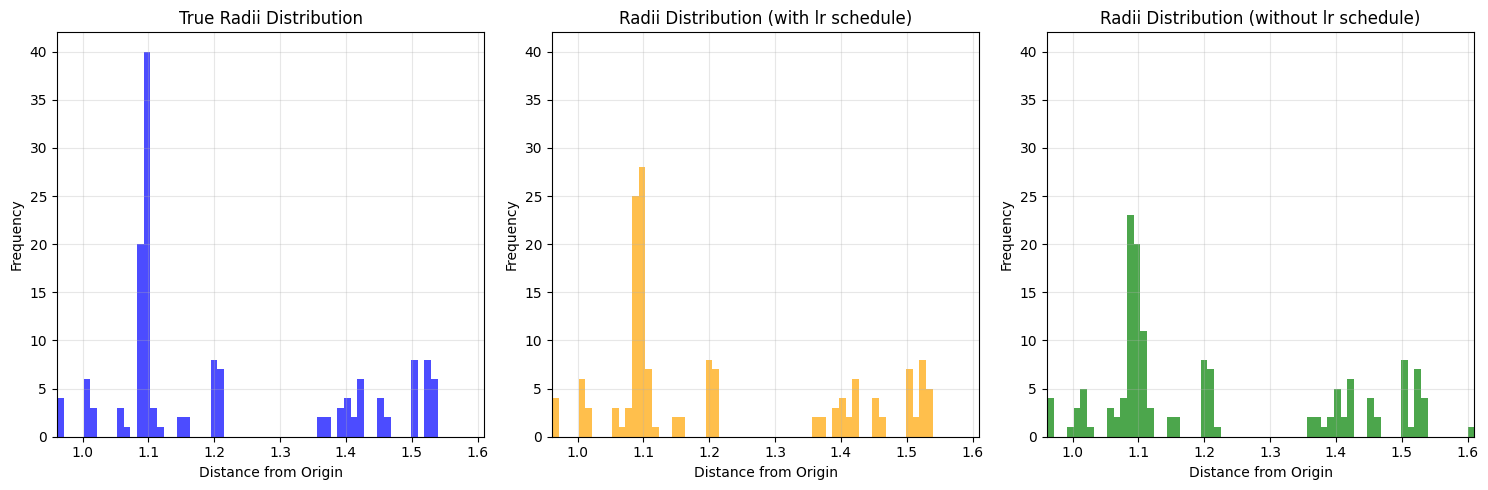

In [54]:
loaded_predicted_geometries = loaded_predicted_geometries[:50]

# Filter environments where the number of neighbors is the same
num_local_envs = len(predicted_geometries)
filtered_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_indices.append(i)

# Get the filtered environments
filtered_true_envs = [local_envs[i] for i in filtered_indices]
filtered_pred_envs = [predicted_geometries[i] for i in filtered_indices]
filtered_loaded_pred_envs = [loaded_predicted_geometries[i] for i in filtered_indices]

# Stack all filtered local environments into a single array
stacked_true_envs = jnp.vstack([jnp.array(env) for env in filtered_true_envs])
stacked_pred_envs = jnp.vstack(filtered_pred_envs)
stacked_loaded_pred_envs = jnp.vstack(filtered_loaded_pred_envs)

# Calculate the row-wise norm (Euclidean distance from origin for each point)
true_norms = jnp.linalg.norm(stacked_true_envs, axis=1)
predicted_norms = jnp.linalg.norm(stacked_pred_envs, axis=1)
loaded_predicted_norms = jnp.linalg.norm(stacked_loaded_pred_envs, axis=1)

# Calculate statistics
avg_true_norm = jnp.mean(true_norms)
std_true_norm = jnp.std(true_norms)
avg_pred_norm = jnp.mean(predicted_norms)
std_pred_norm = jnp.std(predicted_norms)
avg_loaded_pred_norm = jnp.mean(loaded_predicted_norms)
std_loaded_pred_norm = jnp.std(loaded_predicted_norms)

print(f"Number of environments with matching neighbor count: {len(filtered_indices)} out of {num_local_envs}")
print(f"Average distance from origin (true): {avg_true_norm:.6f}")
print(f"Standard deviation of distances (true): {std_true_norm:.6f}")
print(f"Average distance from origin (predicted): {avg_pred_norm:.6f}")
print(f"Standard deviation of distances (predicted): {std_pred_norm:.6f}")
print(f"Average distance from origin (loaded predicted): {avg_loaded_pred_norm:.6f}")
print(f"Standard deviation of distances (loaded predicted): {std_loaded_pred_norm:.6f}")

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Determine common x and y axis limits
min_x = min(jnp.min(true_norms), jnp.min(predicted_norms), jnp.min(loaded_predicted_norms))
max_x = max(jnp.max(true_norms), jnp.max(predicted_norms), jnp.max(loaded_predicted_norms))
# Use buckets of size 0.01
num_bins = int((max_x - min_x) / 0.01) + 1
bins = np.linspace(min_x, max_x, num_bins)

# True distances histogram
counts_true, bins_true, _ = ax1.hist(true_norms, bins=bins, alpha=0.7, color='blue')
ax1.set_xlabel('Distance from Origin')
ax1.set_ylabel('Frequency')
ax1.set_title('True Radii Distribution')
ax1.grid(alpha=0.3)

# Loaded predicted distances histogram
counts_loaded_pred, bins_loaded_pred, _ = ax2.hist(loaded_predicted_norms, bins=bins, alpha=0.7, color='orange')
ax2.set_xlabel('Distance from Origin')
ax2.set_ylabel('Frequency')
ax2.set_title('Radii Distribution (with lr schedule)')
ax2.grid(alpha=0.3)

# Predicted distances histogram
counts_pred, bins_pred, _ = ax3.hist(predicted_norms, bins=bins, alpha=0.7, color='green')
ax3.set_xlabel('Distance from Origin')
ax3.set_ylabel('Frequency')
ax3.set_title('Radii Distribution (without lr schedule)')
ax3.grid(alpha=0.3)

# Get the y-axis limits from all plots and use the same for all
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1], ax3.get_ylim()[1])
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)
ax3.set_ylim(0, y_max)

# Ensure all plots have the same x-axis range
ax1.set_xlim(min_x, max_x)
ax2.set_xlim(min_x, max_x)
ax3.set_xlim(min_x, max_x)

plt.tight_layout()
plt.show()

In [18]:
# Save the predicted geometries to a file
import pickle

# Create a file path
output_file = "predicted_geometries50_lr24.pkl"

# Save the predicted geometries
with open(output_file, "wb") as f:
    pickle.dump(predicted_geometries, f)

print(f"Saved predicted geometries to {output_file}")

Saved predicted geometries to predicted_geometries50_lr24.pkl


In [82]:
# Read in the predicted geometries from the file
import pickle

# Define the file path
input_file = "predicted_geometries.pkl"

# Load the predicted geometries
with open(input_file, "rb") as f:
    loaded_predicted_geometries = pickle.load(f)

# Verify the data was loaded correctly
print(f"Loaded {len(loaded_predicted_geometries)} predicted geometries from {input_file}")

Loaded 450 predicted geometries from predicted_geometries.pkl


Average radius MAE across filtered environments: 0.00193
Standard deviation of radius MAE: 0.00232
Min radius MAE: 0.00000
Max radius MAE: 0.00971


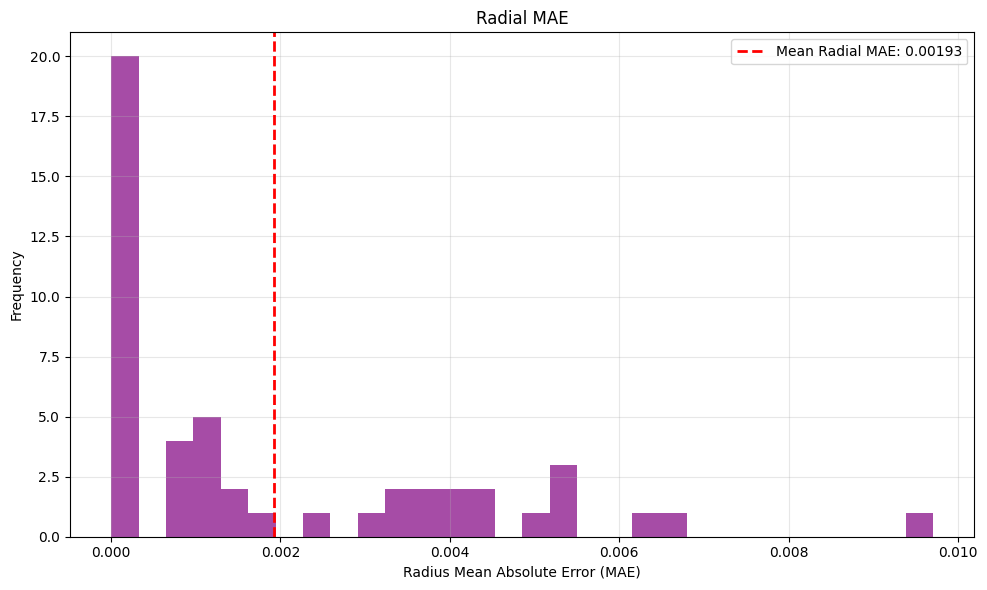

In [39]:
# Filter environments where the number of neighbors is the same
num_local_envs = len(predicted_geometries)
filtered_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_indices.append(i)

# Calculate the Mean Absolute Error (MAE) between true and predicted geometries using radius_mae
# First, ensure we're only using the filtered environments
filtered_true_envs = [local_envs[i] for i in filtered_indices]
filtered_pred_envs = [predicted_geometries[i] for i in filtered_indices]

# Calculate radius MAE for each pair of environments
mae_values = []
for true_env, pred_env in zip(filtered_true_envs, filtered_pred_envs):
    # Convert to arrays if they aren't already
    true_env_array = jnp.array(true_env)
    pred_env_array = jnp.array(pred_env)
    
    # Use radius_mae function to calculate the error
    mae = radius_mae(true_env_array, pred_env_array)
    mae_values.append(mae)

# Convert to array for easier manipulation
mae_values = jnp.array(mae_values)
mae_values = mae_values[mae_values < 0.02]

# Print statistics
print(f"Average radius MAE across filtered environments: {jnp.mean(mae_values):.5f}")
print(f"Standard deviation of radius MAE: {jnp.std(mae_values):.5f}")
print(f"Min radius MAE: {jnp.min(mae_values):.5f}")
print(f"Max radius MAE: {jnp.max(mae_values):.5f}")

# Create histogram of MAE values
plt.figure(figsize=(10, 6))
plt.hist(mae_values, bins=30, alpha=0.7, color='purple')
plt.xlabel('Radius Mean Absolute Error (MAE)')
plt.ylabel('Frequency')
plt.title('Radial MAE')
plt.grid(alpha=0.3)
plt.axvline(jnp.mean(mae_values), color='red', linestyle='dashed', 
            linewidth=2, label=f'Mean Radial MAE: {jnp.mean(mae_values):.5f}')
plt.legend()
plt.tight_layout()
plt.show()


Loaded Predicted Geometries:
Average radius MAE: 0.00097
Standard deviation of radius MAE: 0.00112
Min radius MAE: 0.00000
Max radius MAE: 0.00432

Predicted Geometries:
Average radius MAE: 0.00218
Standard deviation of radius MAE: 0.00232
Min radius MAE: 0.00000
Max radius MAE: 0.00936


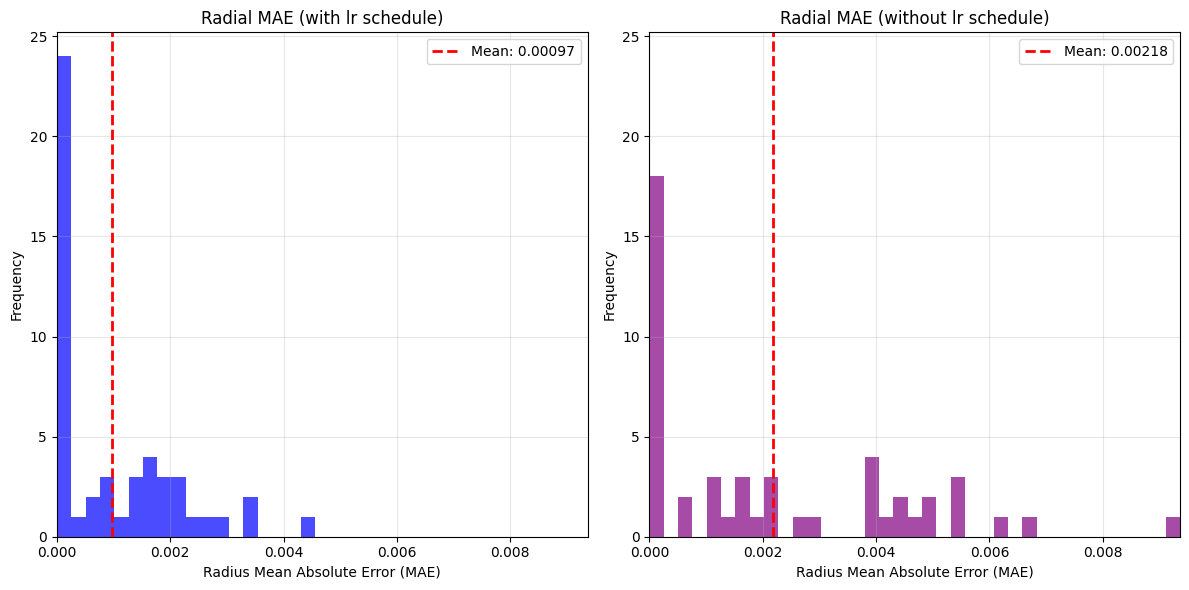

In [92]:
# Create two subplots - one for loaded_predicted_geometries and one for predicted_geometries

# Filter environments where the number of neighbors is the same
# For loaded_predicted_geometries
num_loaded_envs = len(loaded_predicted_geometries)
filtered_loaded_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_loaded_envs], loaded_predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_loaded_indices.append(i)

# For predicted_geometries
num_local_envs = len(predicted_geometries)
filtered_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_indices.append(i)

# Calculate MAE for loaded_predicted_geometries
filtered_true_loaded_envs = [local_envs[i] for i in filtered_loaded_indices]
filtered_loaded_pred_envs = [loaded_predicted_geometries[i] for i in filtered_loaded_indices]

loaded_mae_values = []
for true_env, pred_env in zip(filtered_true_loaded_envs, filtered_loaded_pred_envs):
    true_env_array = jnp.array(true_env)
    pred_env_array = jnp.array(pred_env)
    mae = radius_mae(true_env_array, pred_env_array)
    loaded_mae_values.append(mae)

loaded_mae_values = jnp.array(loaded_mae_values)
loaded_mae_values = loaded_mae_values[loaded_mae_values < 0.1]

# Calculate MAE for predicted_geometries
filtered_true_envs = [local_envs[i] for i in filtered_indices]
filtered_pred_envs = [predicted_geometries[i] for i in filtered_indices]

mae_values = []
for true_env, pred_env in zip(filtered_true_envs, filtered_pred_envs):
    true_env_array = jnp.array(true_env)
    pred_env_array = jnp.array(pred_env)
    mae = radius_mae(true_env_array, pred_env_array)
    mae_values.append(mae)

mae_values = jnp.array(mae_values)
mae_values = mae_values[mae_values < 0.1]

# Print statistics for both
print("Loaded Predicted Geometries:")
print(f"Average radius MAE: {jnp.mean(loaded_mae_values):.5f}")
print(f"Standard deviation of radius MAE: {jnp.std(loaded_mae_values):.5f}")
print(f"Min radius MAE: {jnp.min(loaded_mae_values):.5f}")
print(f"Max radius MAE: {jnp.max(loaded_mae_values):.5f}")
print("\nPredicted Geometries:")
print(f"Average radius MAE: {jnp.mean(mae_values):.5f}")
print(f"Standard deviation of radius MAE: {jnp.std(mae_values):.5f}")
print(f"Min radius MAE: {jnp.min(mae_values):.5f}")
print(f"Max radius MAE: {jnp.max(mae_values):.5f}")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Set min_mae to 0 and determine max_mae
min_mae = 0
max_mae = max(jnp.max(loaded_mae_values), jnp.max(mae_values))

# Calculate bin edges with bin size of 0.0005
bin_size = 0.00025
num_bins = int((max_mae - min_mae) / bin_size) + 1
bin_edges = np.linspace(min_mae, max_mae, num_bins)

# Create histograms to determine the maximum frequency for y-axis limits
hist1, _ = np.histogram(loaded_mae_values, bins=bin_edges)
hist2, _ = np.histogram(mae_values, bins=bin_edges)
max_freq = max(np.max(hist1), np.max(hist2))

# Left subplot for loaded_predicted_geometries
ax1.hist(loaded_mae_values, bins=bin_edges, alpha=0.7, color='blue')
ax1.set_xlabel('Radius Mean Absolute Error (MAE)')
ax1.set_ylabel('Frequency')
ax1.set_title('Radial MAE (with lr schedule)')
ax1.grid(alpha=0.3)
ax1.axvline(jnp.mean(loaded_mae_values), color='red', linestyle='dashed', 
           linewidth=2, label=f'Mean: {jnp.mean(loaded_mae_values):.5f}')
ax1.legend()
ax1.set_xlim(min_mae, max_mae)
ax1.set_ylim(0, max_freq * 1.05)  # Set y-axis limit with a small margin

# Right subplot for predicted_geometries
ax2.hist(mae_values, bins=bin_edges, alpha=0.7, color='purple')
ax2.set_xlabel('Radius Mean Absolute Error (MAE)')
ax2.set_ylabel('Frequency')
ax2.set_title('Radial MAE (without lr schedule)')
ax2.grid(alpha=0.3)
ax2.axvline(jnp.mean(mae_values), color='red', linestyle='dashed', 
           linewidth=2, label=f'Mean: {jnp.mean(mae_values):.5f}')
ax2.legend()
ax2.set_xlim(min_mae, max_mae)
ax2.set_ylim(0, max_freq * 1.05)  # Set y-axis limit with a small margin

plt.tight_layout()
plt.show()


In [16]:
import numpy as np
from itertools import permutations, combinations

def angle_mae(arr1, arr2):
    """
    Compute the minimum average of the absolute differences between all pairwise angles
    in two geometries by trying all possible permutations of the second array.
    
    Parameters:
    arr1 (numpy.ndarray): First array of 3D coordinates representing a geometry
    arr2 (numpy.ndarray): Second array of 3D coordinates representing a geometry of the same size
    
    Returns:
    float: Minimum average absolute difference between all pairwise angles
    """
    
    # Convert JAX arrays to NumPy if needed
    if hasattr(arr1, 'device_buffer'):
        arr1 = np.array(arr1)
    if hasattr(arr2, 'device_buffer'):
        arr2 = np.array(arr2)
    
    if len(arr1) != len(arr2):
        return np.nan
    
    if len(arr1) <= 2:  # Need at least 3 points to form angles
        return 0.0
    
    # Calculate all pairwise angles for arr1
    def calculate_angles(points):
        angles = []
        for i, j, k in combinations(range(len(points)), 3):
            # Vectors from j to i and j to k
            v1 = points[i] - points[j]
            v2 = points[k] - points[j]
            
            # Normalize vectors
            v1_norm = np.linalg.norm(v1)
            v2_norm = np.linalg.norm(v2)
            
            # Avoid division by zero
            if v1_norm == 0 or v2_norm == 0:
                continue
                
            v1 = v1 / v1_norm
            v2 = v2 / v2_norm
            
            # Calculate angle using dot product
            dot_product = np.clip(np.dot(v1, v2), -1.0, 1.0)
            angle = np.arccos(dot_product)
            angles.append(angle)
        
        return np.array(angles)
    
    arr1_angles = calculate_angles(arr1)
    
    min_avg = float('inf')
    
    # Generate all permutations of arr2
    for perm_indices in permutations(range(len(arr2))):
        # Use numpy indexing with tuple instead of list to avoid JAX error
        perm_arr2 = np.array([arr2[i] for i in perm_indices])
        arr2_angles = calculate_angles(perm_arr2)
        
        # If the number of angles doesn't match, skip this permutation
        if len(arr1_angles) != len(arr2_angles):
            continue
        
        # Calculate absolute differences in angles
        abs_diff = np.abs(arr1_angles - arr2_angles)
        
        # Take the minimum of the difference and 2π-difference (for angle wrapping)
        abs_diff = np.minimum(abs_diff, 2*np.pi - abs_diff)
        
        # Calculate mean of absolute differences
        avg_diff = np.mean(abs_diff)
        
        # Update minimum if current permutation gives better result
        if avg_diff < min_avg:
            min_avg = avg_diff
    
    return float(min_avg)

Average angle MAE across filtered environments: 0.11342°
Standard deviation of angle MAE: 0.12801°
Min angle MAE: 0.00000°
Max angle MAE: 0.42313°


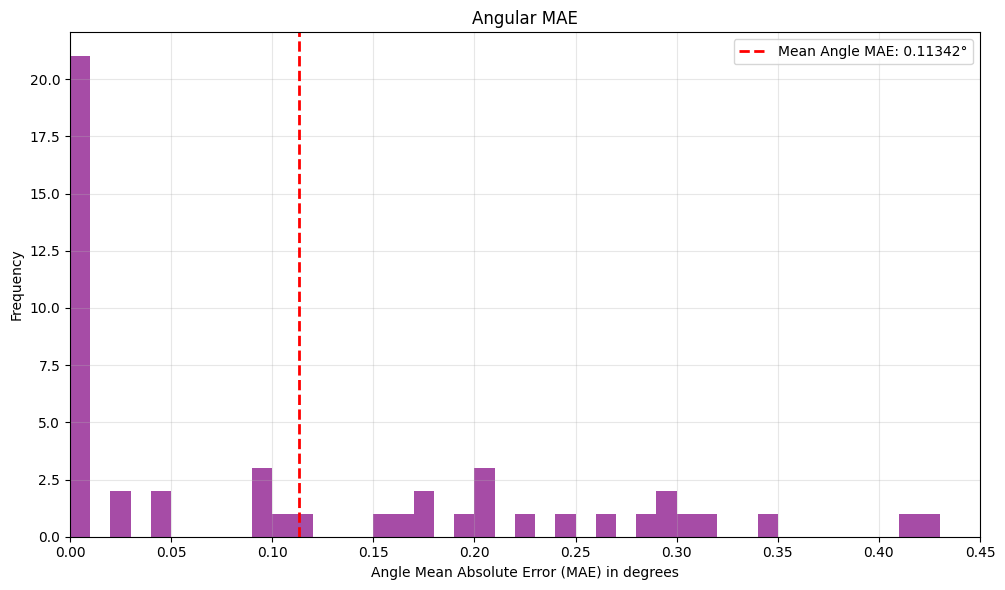

In [80]:
# Filter environments where the number of neighbors is the same
num_local_envs = len(predicted_geometries)
filtered_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_indices.append(i)

# Calculate the Mean Absolute Error (MAE) between true and predicted geometries using angle_mae
# First, ensure we're only using the filtered environments
filtered_true_envs = [local_envs[i] for i in filtered_indices]
filtered_pred_envs = [predicted_geometries[i] for i in filtered_indices]

# # Filter environments where the number of neighbors is the same
# loaded_predicted_geometries = loaded_predicted_geometries[:50]
# num_local_envs = len(loaded_predicted_geometries)
# filtered_indices = []
# for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], loaded_predicted_geometries)):
#     if len(true_env) == len(pred_env):
#         filtered_indices.append(i)

# # Calculate the Mean Absolute Error (MAE) between true and predicted geometries using angle_mae
# # First, ensure we're only using the filtered environments
# filtered_true_envs = [local_envs[i] for i in filtered_indices]
# filtered_pred_envs = [loaded_predicted_geometries[i] for i in filtered_indices]

# Calculate angle MAE for each pair of environments
mae_values = []
for true_env, pred_env in zip(filtered_true_envs, filtered_pred_envs):
    # Convert to arrays if they aren't already
    true_env_array = np.array(true_env)
    pred_env_array = np.array(pred_env)
    
    # Use angle_mae function to calculate the error
    mae = angle_mae(true_env_array, pred_env_array)
    # Convert radians to degrees
    mae_degrees = np.degrees(mae)
    mae_values.append(mae_degrees)

# Convert to array for easier manipulation
mae_values = jnp.array(mae_values)
mae_values = mae_values[mae_values < 2.5]

# Print statistics
print(f"Average angle MAE across filtered environments: {jnp.mean(mae_values):.5f}°")
print(f"Standard deviation of angle MAE: {jnp.std(mae_values):.5f}°")
print(f"Min angle MAE: {jnp.min(mae_values):.5f}°")
print(f"Max angle MAE: {jnp.max(mae_values):.5f}°")

# Create histogram of MAE values with specific bin size
plt.figure(figsize=(10, 6))
bins = np.arange(0.0, 0.45 + 0.01, 0.01)  # Create bins from 0.0 to 0.45 with step 0.01
plt.hist(mae_values, bins=bins, alpha=0.7, color='purple')
plt.xlabel('Angle Mean Absolute Error (MAE) in degrees')
plt.ylabel('Frequency')
plt.title('Angular MAE')
plt.grid(alpha=0.3)
plt.axvline(jnp.mean(mae_values), color='red', linestyle='dashed', 
            linewidth=2, label=f'Mean Angle MAE: {jnp.mean(mae_values):.5f}°')
plt.legend()
plt.tight_layout()

# Set x-axis limits explicitly
plt.xlim(0, 0.45)

plt.show()


Average angle MAE across filtered environments: 0.06326°
Standard deviation of angle MAE: 0.15378°
Min angle MAE: 0.00000°
Max angle MAE: 1.55156°


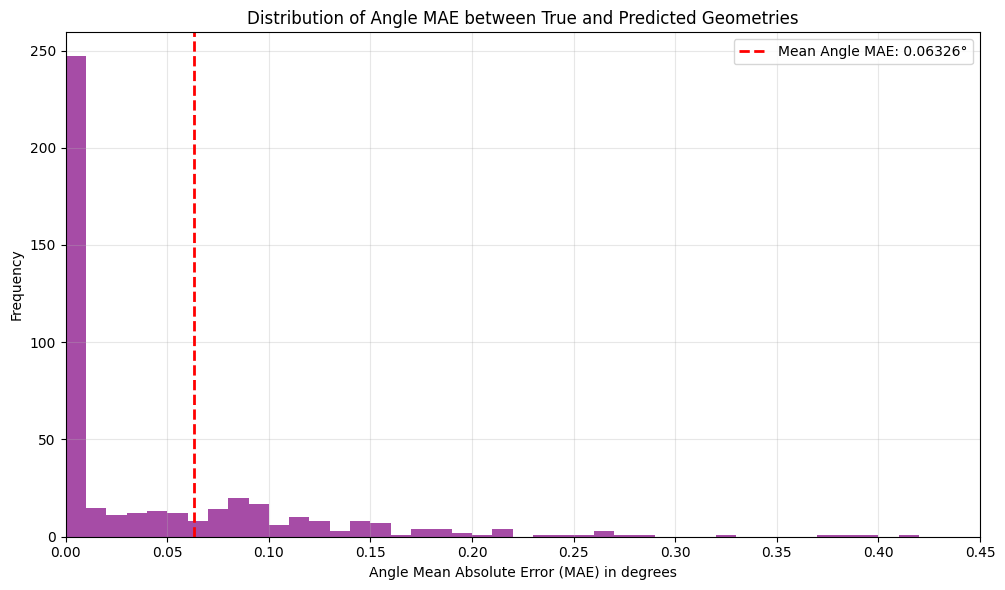

In [84]:
# Filter environments where the number of neighbors is the same
num_local_envs = len(loaded_predicted_geometries)
filtered_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], loaded_predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_indices.append(i)

# Calculate the Mean Absolute Error (MAE) between true and predicted geometries using angle_mae
# First, ensure we're only using the filtered environments
filtered_true_envs = [local_envs[i] for i in filtered_indices]
filtered_pred_envs = [loaded_predicted_geometries[i] for i in filtered_indices]

# Calculate angle MAE for each pair of environments
mae_values = []
for true_env, pred_env in zip(filtered_true_envs, filtered_pred_envs):
    # Convert to arrays if they aren't already
    true_env_array = np.array(true_env)
    pred_env_array = np.array(pred_env)
    
    # Use angle_mae function to calculate the error
    mae = angle_mae(true_env_array, pred_env_array)
    # Convert radians to degrees
    mae_degrees = np.degrees(mae)
    mae_values.append(mae_degrees)

# Convert to array for easier manipulation
mae_values = jnp.array(mae_values)

# Print statistics
print(f"Average angle MAE across filtered environments: {jnp.mean(mae_values):.5f}°")
print(f"Standard deviation of angle MAE: {jnp.std(mae_values):.5f}°")
print(f"Min angle MAE: {jnp.min(mae_values):.5f}°")
print(f"Max angle MAE: {jnp.max(mae_values):.5f}°")

# Create histogram of MAE values with specific bin size
plt.figure(figsize=(10, 6))
bins = np.arange(0.0, 0.45 + 0.01, 0.01)  # Create bins from 0.0 to 0.45 with step 0.01
plt.hist(mae_values, bins=bins, alpha=0.7, color='purple')
plt.xlabel('Angle Mean Absolute Error (MAE) in degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Angle MAE between True and Predicted Geometries')
plt.grid(alpha=0.3)
plt.axvline(jnp.mean(mae_values), color='red', linestyle='dashed', 
            linewidth=2, label=f'Mean Angle MAE: {jnp.mean(mae_values):.5f}°')
plt.legend()
plt.tight_layout()

# Set x-axis limits explicitly
plt.xlim(0, 0.45)

plt.show()

Loaded Predicted Geometries:
Average angle MAE across filtered environments: 0.05627°
Standard deviation of angle MAE: 0.07082°
Min angle MAE: 0.00000°
Max angle MAE: 0.25682°

Predicted Geometries:
Average angle MAE across filtered environments: 0.11342°
Standard deviation of angle MAE: 0.12801°
Min angle MAE: 0.00000°
Max angle MAE: 0.42313°


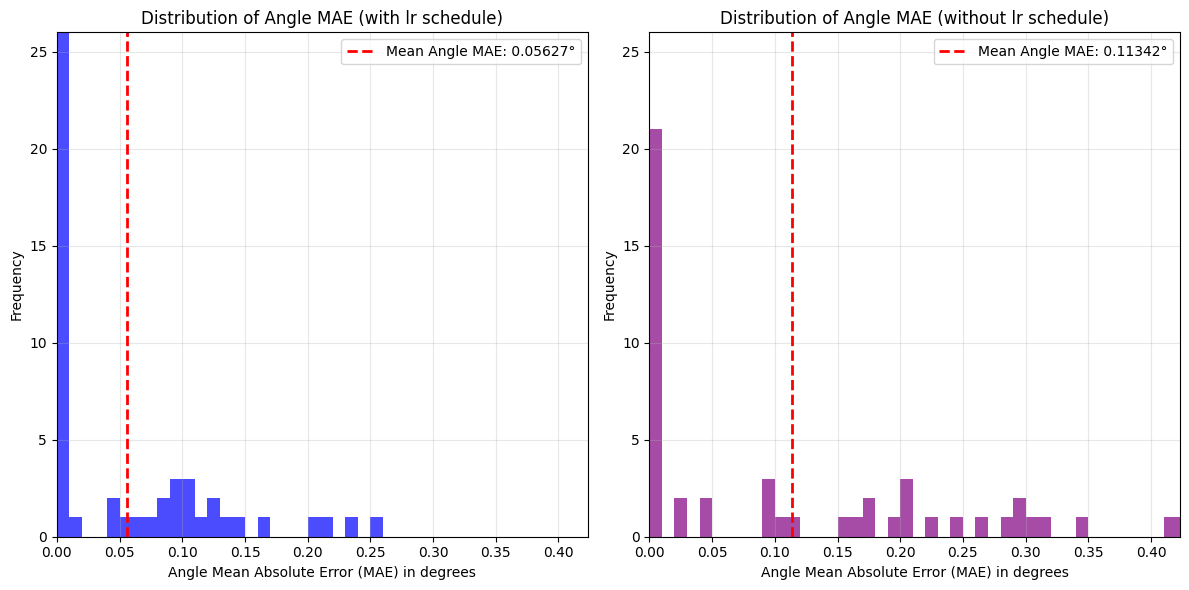

In [91]:
# Create two subplots - one for loaded_predicted_geometries and one for predicted_geometries

# Filter environments where the number of neighbors is the same
# For loaded_predicted_geometries
loaded_predicted_geometries = loaded_predicted_geometries[:50]
num_loaded_envs = len(loaded_predicted_geometries)
filtered_loaded_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_loaded_envs], loaded_predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_loaded_indices.append(i)

# For predicted_geometries
num_local_envs = len(predicted_geometries)
filtered_indices = []
for i, (true_env, pred_env) in enumerate(zip(local_envs[:num_local_envs], predicted_geometries)):
    if len(true_env) == len(pred_env):
        filtered_indices.append(i)

# Calculate MAE for loaded_predicted_geometries
filtered_true_loaded_envs = [local_envs[i] for i in filtered_loaded_indices]
filtered_loaded_pred_envs = [loaded_predicted_geometries[i] for i in filtered_loaded_indices]

loaded_mae_values = []
for true_env, pred_env in zip(filtered_true_loaded_envs, filtered_loaded_pred_envs):
    # Convert to arrays if they aren't already
    true_env_array = np.array(true_env)
    pred_env_array = np.array(pred_env)
    
    # Use angle_mae function to calculate the error
    mae = angle_mae(true_env_array, pred_env_array)
    # Convert radians to degrees
    mae_degrees = np.degrees(mae)
    loaded_mae_values.append(mae_degrees)

loaded_mae_values = jnp.array(loaded_mae_values)
loaded_mae_values = loaded_mae_values[loaded_mae_values < 2.5]

# Calculate MAE for predicted_geometries
filtered_true_envs = [local_envs[i] for i in filtered_indices]
filtered_pred_envs = [predicted_geometries[i] for i in filtered_indices]

mae_values = []
for true_env, pred_env in zip(filtered_true_envs, filtered_pred_envs):
    # Convert to arrays if they aren't already
    true_env_array = np.array(true_env)
    pred_env_array = np.array(pred_env)
    
    # Use angle_mae function to calculate the error
    mae = angle_mae(true_env_array, pred_env_array)
    # Convert radians to degrees
    mae_degrees = np.degrees(mae)
    mae_values.append(mae_degrees)

mae_values = jnp.array(mae_values)
mae_values = mae_values[mae_values < 2.5]

# Print statistics for both
print("Loaded Predicted Geometries:")
print(f"Average angle MAE across filtered environments: {jnp.mean(loaded_mae_values):.5f}°")
print(f"Standard deviation of angle MAE: {jnp.std(loaded_mae_values):.5f}°")
print(f"Min angle MAE: {jnp.min(loaded_mae_values):.5f}°")
print(f"Max angle MAE: {jnp.max(loaded_mae_values):.5f}°")
print("\nPredicted Geometries:")
print(f"Average angle MAE across filtered environments: {jnp.mean(mae_values):.5f}°")
print(f"Standard deviation of angle MAE: {jnp.std(mae_values):.5f}°")
print(f"Min angle MAE: {jnp.min(mae_values):.5f}°")
print(f"Max angle MAE: {jnp.max(mae_values):.5f}°")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Compute common x-axis limits from the data
min_value = min(jnp.min(loaded_mae_values), jnp.min(mae_values))
max_value = max(jnp.max(loaded_mae_values), jnp.max(mae_values))
# Add a small buffer for better visualization
x_max = max_value

# Create bins of size 0.01
bins = np.arange(0, x_max + 0.01, 0.01)  # Create bins from 0 to x_max with step 0.01

# Calculate histograms to determine y-axis limits
hist1, _ = np.histogram(loaded_mae_values, bins=bins)
hist2, _ = np.histogram(mae_values, bins=bins)
y_max = max(np.max(hist1), np.max(hist2))

# Left subplot for loaded_predicted_geometries
ax1.hist(loaded_mae_values, bins=bins, alpha=0.7, color='blue')
ax1.set_xlabel('Angle Mean Absolute Error (MAE) in degrees')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Angle MAE (with lr schedule)')
ax1.grid(alpha=0.3)
ax1.axvline(jnp.mean(loaded_mae_values), color='red', linestyle='dashed', 
           linewidth=2, label=f'Mean Angle MAE: {jnp.mean(loaded_mae_values):.5f}°')
ax1.legend()
ax1.set_xlim(0, x_max)
ax1.set_ylim(0, y_max)

# Right subplot for predicted_geometries
ax2.hist(mae_values, bins=bins, alpha=0.7, color='purple')
ax2.set_xlabel('Angle Mean Absolute Error (MAE) in degrees')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Angle MAE (without lr schedule)')
ax2.grid(alpha=0.3)
ax2.axvline(jnp.mean(mae_values), color='red', linestyle='dashed', 
           linewidth=2, label=f'Mean Angle MAE: {jnp.mean(mae_values):.5f}°')
ax2.legend()
ax2.set_xlim(0, x_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()


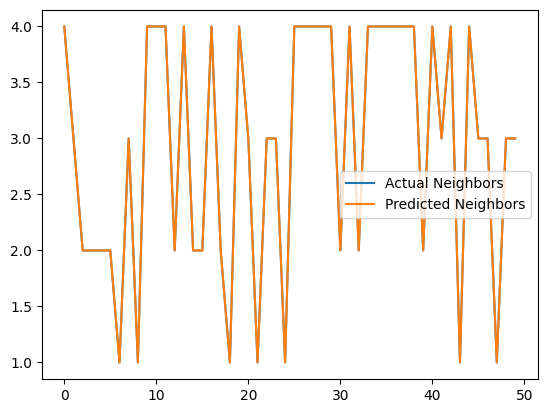

In [37]:
num_actual_neighbors = [len(local_envs[i]) for i in range(len(local_envs[:50]))]
num_predicted_neighbors = [len(predicted_geometries[i]) for i in range(len(predicted_geometries[:50]))]

plt.plot(num_actual_neighbors, label='Actual Neighbors')
plt.plot(num_predicted_neighbors, label='Predicted Neighbors')
plt.legend()